In [79]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import normalize

**Steps followed**
1. import the daily stock data (adj close) and form a matrix. Row = Days, Cols = Stocks/cash
2. define dummy policy. 
        a) random daily weights
        b) equal weighting
        c) rule based weighting buy if stock last time step, sell if not
        d) ML
3. use policy to determine daily policy weights. Rows = Days, Cols = Stock/Cash
4. Element wise multiplication #1 and #3.
5. Calculate the return over time across stocks. => Sum each row.
6. Compute the cumulative product. np.cumprod()
7. 

In [80]:
def read_stock(path="../resources/ML4T/ML4T_assignments/data/",stocks=None):
    i = 0
    for stock in stocks:
        stock_path = path+stock
        if i == 0:
            df = pd.read_csv(stock_path)[['Date','Adj Close']].rename(columns={'Adj Close':stock.strip('.csv')})
        else:
            df = df.merge(pd.read_csv(stock_path)[['Date','Adj Close']].rename(columns={'Adj Close':stock.strip('.csv')}),on='Date')
        i +=1
    df.index = pd.to_datetime(df.Date)
    df = df.drop(columns='Date').sort_index()
    df = df/df.iloc[0]
    return df

In [81]:
res = read_stock(stocks=["jpm.csv","GOOG.csv","ibm.csv"])
res.head()

,jpm,GOOG,ibm
Date,,,
2004-08-19,1.000000,1.000000,1.000000
2004-08-20,1.017197,1.079430,1.004266
2004-08-23,1.014601,1.090293,0.997200
2004-08-24,1.015574,1.045147,0.997867
2004-08-25,1.037962,1.056408,1.002133


In [82]:
def equal_weight(stock_table):
    return 1/stock_table.shape[1]*np.ones(stock_table.shape)

def random_weight(stock_table):
    return np.random.dirichlet(np.random.uniform(size=stock_table.shape[1]),stock_table.shape[0])


In [83]:
def rule_based(stock_table):
    vals = np.ones(stock_table.shape)
    k = 378
    st = np.ones(stock_table.shape)
    st[1:] = stock_table[1:].values / stock_table[:-1].values
    for i in range(k,len(st)):
        vals[i] = np.where(st[i-1]>st[i-k-1],1,0) 
        if np.sum(vals[i]) == 0:
            vals[i] = np.array([1/stock_table.shape[1]]*stock_table.shape[1])
    final_vals = normalize(vals,axis=1,norm='l1')
    return final_vals

In [84]:
def ols(stock_table):
    vals = np.ones(stock_table.shape)
    k = 0
    for col in stock_table:
        st = np.ones(stock_table.shape[0])
        st[1:] = stock_table.iloc[1:,k].values / stock_table.iloc[:-1,k].values
        for i in range(len(st)):
            if i in [0,1,2,3]:
                vals[i,k] = 1/stock_table.shape[1]
            else:
                st_cur = st[max(1,i-378):i]
                x = np.arange(len(st_cur)-1)
                vals[i,k] = sm.OLS(st_cur[:-1],x).fit().predict(len(st_cur))
        k+=1
    final_vals = vals.copy()
    final_vals[4:] = normalize(np.apply_along_axis(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)),1,vals[4:]), axis=1, norm='l1')
        
    return final_vals

In [85]:
def enact(stock_table,policy):
    st = np.ones(stock_table.shape)
    st[1:] = stock_table[1:].values / stock_table[:-1].values
    p = policy(stock_table)
    v = np.multiply(st,p).sum(axis=1)
    cp = np.cumprod(v)
    return cp

In [90]:
def plot_returns(stocks=["AAPL.csv","GOOG.csv"], policies=[equal_weight, ols, rule_based,random_weight]):
    stock_table = read_stock(stocks=["kr.csv","wmt.csv","hd.csv","cost.csv","tgt.csv","low.csv","shld.csv","cvs.csv","bby.csv","jcp.csv","gps.csv"])
    for policy in policies:
        cp = enact(stock_table,policy)
        plt.plot(cp,label = policy.__name__)
    plt.legend()
    plt.xlabel("Number of days")
    plt.ylabel("Value of portfolio return multiplier")    
    plt.show()

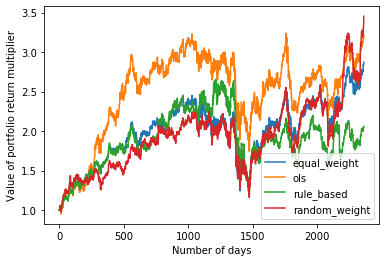

In [91]:
plot_returns()